# Phase 2 Group 11

Since the file we have is over 1 GB the first step is to shrink it down to a useable size.

We selected to look at only the year 2017 and then removed null and mostly null columns.

The data set was sampled down to 20,000 rows so we can perform the rest of the tasks and phases in a timely manner, without running out of memory, or taking hours to compute.


# Load and cache data

In [1]:
val df = spark.read.format("csv")
  .option("inferSchema", "true")
  .option("header", "true")
  .load("LCLoan.csv")

Intitializing Scala interpreter ...

Spark Web UI available at http://75cd00854c39:4040
SparkContext available as 'sc' (version = 2.4.3, master = local[*], app id = local-1558792816683)
SparkSession available as 'spark'


2019-05-25 14:00:15,080 WARN  [main] util.NativeCodeLoader (NativeCodeLoader.java:<clinit>(62)) - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


df: org.apache.spark.sql.DataFrame = [id: string, member_id: string ... 143 more fields]


In [2]:
// cache in memory to speed up
df.cache
df.count

# Register temp table for use in Spark SQL

In [3]:
df.createOrReplaceTempView("df")

2019-05-25 14:01:56,593 WARN  [Thread-4] util.Utils (Logging.scala:logWarning(66)) - Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.debug.maxToStringFields' in SparkEnv.conf.


In [4]:
spark.sql("select * from df").show(5,false)

+----+---------+---------+-----------+---------------+----------+--------+-----------+-----+---------+--------------+----------+--------------+----------+-------------------+--------+-----------+----------+----+----+------------------+------------------+--------+----------+-----+-----------+----------------+--------------+----------------------+----------------------+--------+-------+---------+----------+---------+-------------------+---------+-------------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+------------+---------------+------------+------------------+--------------------------+---------------------------+-----------+----------------+----------------+---------+-------------------------+--------------+------------+-----------+-----------+-----------+-----------+-----------+------------------+------------+-------+-----------+-----------+----------+--------+----------------+------+-----------+------------+-------

|null|null     |4000     |4000       |4000.0         | 36 months|18.94   |146.51     |D    |D2       |IT Supervisor |10+ years |MORTGAGE      |92000     |Source Verified    |Dec-2018|Current    |n         |null|null|debt_consolidation|Debt consolidation|985xx   |WA        |16.74|0          |Feb-2006        |0             |null                  |null                  |10      |0      |5468     |78.1      |13       |w                  |3831.93  |3831.93      |286.71     |286.71         |168.07         |118.64       |0.0               |0.0       |0.0                    |Feb-2019    |146.51         |Mar-2019    |Feb-2019          |0                         |null                       |1          |Individual      |null            |null     |null                     |0             |686         |305049     |1          |5          |3          |5          |5                 |30683       |68     |0          |0          |3761      |70      |7000            |2     |4          |3           |5      

# Drop fields with population rate lower than 90%

In [5]:
// get all columns
val selectColumns = df.columns.toArray

selectColumns: Array[String] = Array(id, member_id, loan_amnt, funded_amnt, funded_amnt_inv, term, int_rate, installment, grade, sub_grade, emp_title, emp_length, home_ownership, annual_inc, verification_status, issue_d, loan_status, pymnt_plan, url, desc, purpose, title, zip_code, addr_state, dti, delinq_2yrs, earliest_cr_line, inq_last_6mths, mths_since_last_delinq, mths_since_last_record, open_acc, pub_rec, revol_bal, revol_util, total_acc, initial_list_status, out_prncp, out_prncp_inv, total_pymnt, total_pymnt_inv, total_rec_prncp, total_rec_int, total_rec_late_fee, recoveries, collection_recovery_fee, last_pymnt_d, last_pymnt_amnt, next_pymnt_d, last_credit_pull_d, collections_12_mths_ex_med, mths_since_last_major_derog, policy_code, application_type, annual_inc_joint, dti_joint, v...

In [6]:
// Whole file count
val fileCount = df.count

fileCount: Long = 2260668


In [7]:
// Threshold
val sparseThreshold = 0.9

sparseThreshold: Double = 0.9


In [8]:
// Get the list of good columns
var goodColumns = Array[String]()
for (s <- selectColumns) {
    
    // get the counts of not null values for give column
    val sqlText = s"select count(1) as cnt from df where ${s} is not null"
    val not_null_count = spark.sql(sqlText)
    val not_null_int = not_null_count.select("cnt").collect().map(_(0)).toList(0).toString.toDouble
    
    // output the columnss with population rate above threshold
    val populationRate = not_null_int / fileCount
    if ( populationRate >= sparseThreshold) {
        println(s"${s}: ${not_null_int}: ${populationRate}")
        goodColumns = goodColumns :+ s
    }
}

loan_amnt: 2260668.0: 1.0
funded_amnt: 2260668.0: 1.0
funded_amnt_inv: 2260668.0: 1.0
term: 2260668.0: 1.0
int_rate: 2260668.0: 1.0
installment: 2260668.0: 1.0
grade: 2260668.0: 1.0
sub_grade: 2260668.0: 1.0
emp_title: 2093737.0: 0.9261585513662334
emp_length: 2260668.0: 1.0
home_ownership: 2260668.0: 1.0
annual_inc: 2260664.0: 0.999998230611483
verification_status: 2260668.0: 1.0
issue_d: 2260668.0: 1.0
loan_status: 2260668.0: 1.0
pymnt_plan: 2260668.0: 1.0
purpose: 2260667.0: 0.9999995576528707
title: 2237345.0: 0.9896831379043717
zip_code: 2260666.0: 0.9999991153057415
addr_state: 2260667.0: 0.9999995576528707
dti: 2258956.0: 0.9992427017147144
delinq_2yrs: 2260638.0: 0.9999867295861223
earliest_cr_line: 2260638.0: 0.9999867295861223
inq_last_6mths: 2260637.0: 0.9999862872389931
open_acc: 2260558.0: 0.9999513418157819
pub_rec: 2260576.0: 0.9999593040641085
revol_bal: 2260614.0: 0.9999761132550202
revol_util: 2258834.0: 0.9991887353649452
total_acc: 2260618.0: 0.9999778826435373
init

goodColumns: Array[String] = Array(loan_amnt, funded_amnt, funded_amnt_inv, term, int_rate, installment, grade, sub_grade, emp_title, emp_length, home_ownership, annual_inc, verification_status, issue_d, loan_status, pymnt_plan, purpose, title, zip_code, addr_state, dti, delinq_2yrs, earliest_cr_line, inq_last_6mths, open_acc, pub_rec, revol_bal, revol_util, total_acc, initial_list_status, out_prncp, out_prncp_inv, total_pymnt, total_pymnt_inv, total_rec_prncp, total_rec_int, total_rec_late_fee, recoveries, collection_recovery_fee, last_pymnt_d, last_pymnt_amnt, last_credit_pull_d, collections_12_mths_ex_med, policy_code, application_type, acc_now_delinq, tot_coll_amt, tot_cur_bal, total_rev_hi_lim, acc_open_past_24mths, avg_cur_bal, bc_open_to_buy, bc_util, chargeoff_within_12_mths, de...

In [9]:
// Column number reduced to 86
goodColumns.size

res4: Int = 86


In [10]:
val goodColumnsStr = goodColumns.mkString(",")

goodColumnsStr: String = loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_re...

In [11]:
val dfGoodColumn = spark.sql(s"select ${goodColumnsStr} from df")

dfGoodColumn: org.apache.spark.sql.DataFrame = [loan_amnt: int, funded_amnt: int ... 84 more fields]


In [12]:
dfGoodColumn.printSchema

root
 |-- loan_amnt: integer (nullable = true)
 |-- funded_amnt: integer (nullable = true)
 |-- funded_amnt_inv: double (nullable = true)
 |-- term: string (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- installment: double (nullable = true)
 |-- grade: string (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- emp_title: string (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: string (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- issue_d: string (nullable = true)
 |-- loan_status: string (nullable = true)
 |-- pymnt_plan: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- title: string (nullable = true)
 |-- zip_code: string (nullable = true)
 |-- addr_state: string (nullable = true)
 |-- dti: string (nullable = true)
 |-- delinq_2yrs: string (nullable = true)
 |-- earliest_cr_line: string (nullable = true)
 |-- inq_last_6mths: string (nullab

In [13]:
dfGoodColumn.createOrReplaceTempView("dfGoodColumn")

# Retain only 2017 data

In [14]:
val df_2017 = spark.sql("select * from dfGoodColumn where issue_d like '%2017'")

df_2017: org.apache.spark.sql.DataFrame = [loan_amnt: int, funded_amnt: int ... 84 more fields]


In [15]:
// Reduced count to 443579
df_2017.count

res7: Long = 443579


In [16]:
// Verify all records from 2017
df_2017.select("issue_d").distinct.show(false)

+--------+
|issue_d |
+--------+
|Sep-2017|
|Jun-2017|
|Nov-2017|
|Feb-2017|
|Dec-2017|
|Aug-2017|
|May-2017|
|Jul-2017|
|Jan-2017|
|Oct-2017|
|Mar-2017|
|Apr-2017|
+--------+



In [17]:
df_2017.repartition(1).write.csv("LCLoan_2017.csv")

org.apache.spark.sql.AnalysisException:  path file:/home/LCLoan_2017.csv already exists.;

# Sampling down to ~20,000 rows
This is to ensure that we can run further analysis in a timely manner.

In [22]:
//created a subset of our large dataset
//at 4.5% of the 2017 data, this should result in about 20,000 rows 
//the random seed here is 5202L, this is to ensre we can repeat this an get the same 20,000 row sample

var df_2017_20k = df_2017.sample(false, 0.045, 5202L)



//display the size of our final sampled set, and a summary of our target variable, 

df_2017_20k.count

df_2017_20k: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [loan_amnt: int, funded_amnt: int ... 84 more fields]
res14: Long = 20070


In [23]:
//and ensure that none of the counts are too out-of-line with the large dataset
df_2017_20k.groupBy("loan_status").count().show()

+------------------+-----+
|       loan_status|count|
+------------------+-----+
|        Fully Paid| 5446|
|           Default|    1|
|   In Grace Period|  136|
|       Charged Off| 1660|
|Late (31-120 days)|  367|
|           Current|12402|
| Late (16-30 days)|   58|
+------------------+-----+



In [25]:
//Write a Folder that contains a new csv file. (it will be called part-0000-...)

df_2017_20k.coalesce(1).write.format("com.databricks.spark.csv").option("header", "true").save("SubsetLCLoan_2017_20k")

# EDA Section Table of Content

* [#Read-20k-file](#Read-20k-file)
* [#EDA](#EDA)
* [#Correlation-Test](#Correlation-Test)
* [#Visualisations](#Visualisations)

# Read 20k file

In [26]:
var df = spark.read.format("csv")
  .option("inferSchema", "true")
  .option("header", "true")
  .load("Loan_2017_20k.csv")

df: org.apache.spark.sql.DataFrame = [loan_amnt: int, funded_amnt: int ... 84 more fields]


In [27]:
// cache in memory to speed up
df.cache
df.count

2019-05-27 01:31:33,902 WARN  [Thread-4] util.Utils (Logging.scala:logWarning(66)) - Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.debug.maxToStringFields' in SparkEnv.conf.


res23: Long = 20070


In [28]:
df.createOrReplaceTempView("df")

# EDA
* [#Update-Loan-Status](#Update-Loan-Status)
* [#Fill-NA](#Fill-NA)
* [#Check-for-String-type-column](#Check-for-String-type-column)
* [#Check-for-Integer-type-column](#Check-for-Integer-type-column)
* [#Check-for-Double-type-column](#Check-for-Double-type-column)

## Update Loan Status

Merge the loan status to 
- 0: indicates for good loan
- 1: indicates for bad loan

In [29]:
df.groupBy("loan_status").count().show()

+------------------+-----+
|       loan_status|count|
+------------------+-----+
|        Fully Paid| 5446|
|           Default|    1|
|   In Grace Period|  136|
|       Charged Off| 1660|
|Late (31-120 days)|  367|
|           Current|12402|
| Late (16-30 days)|   58|
+------------------+-----+



In [30]:
df.createOrReplaceTempView("df")

In [31]:
val newDF = spark.sql("""
    select a.*,
    case when loan_status in ('Fully Paid', 'In Grace Period', 'Current') then 1 else 0 end as new_loan_status
    from df a
""")

newDF: org.apache.spark.sql.DataFrame = [loan_amnt: int, funded_amnt: int ... 85 more fields]


In [32]:
df = newDF.drop("loan_status").withColumnRenamed("new_loan_status","loan_status")

df: org.apache.spark.sql.DataFrame = [loan_amnt: int, funded_amnt: int ... 84 more fields]


In [33]:
df.groupBy("loan_status").count().show()

+-----------+-----+
|loan_status|count|
+-----------+-----+
|          1|17984|
|          0| 2086|
+-----------+-----+



## Fill NA
* for Integer -> 0
* for String -> ""
* for Double -> 0.0

In [34]:
// Generate a map for each field and it's filled value if na
val typeMap = df.dtypes.map(column => 
    column._2 match {
        case "IntegerType" => (column._1 -> 0)
        case "StringType" => (column._1 -> "")
        case "DoubleType" => (column._1 -> 0.0)
    }).toMap

typeMap: scala.collection.immutable.Map[String,Any] = Map(emp_title -> "", tot_coll_amt -> 0, zip_code -> "", home_ownership -> "", num_bc_sats -> 0, total_pymnt -> 0.0, pct_tl_nvr_dlq -> 0.0, avg_cur_bal -> 0, sub_grade -> "", chargeoff_within_12_mths -> 0.0, pymnt_plan -> "", collection_recovery_fee -> 0.0, inq_last_6mths -> 0, tot_hi_cred_lim -> 0, total_il_high_credit_limit -> 0, last_credit_pull_d -> "", recoveries -> 0.0, total_rec_late_fee -> 0.0, mo_sin_rcnt_tl -> 0, emp_length -> "", policy_code -> 0, num_actv_rev_tl -> 0, mo_sin_old_il_acct -> 0.0, mo_sin_rcnt_rev_tl_op -> 0, verification_status -> "", revol_bal -> 0, num_actv_bc_tl -> 0, num_tl_90g_dpd_24m -> 0, num_tl_op_past_12m -> 0, num_sats -> 0, term -> "", mort_acc -> 0, percent_bc_gt_75 -> 0.0, bc_open_to_buy -> 0, la...

In [35]:
df = df.na.fill(typeMap)

df: org.apache.spark.sql.DataFrame = [loan_amnt: int, funded_amnt: int ... 84 more fields]


In [36]:
// Verify there's no NA in dataframe now
df.na.drop.count

res28: Long = 20070


## Check for String type column

In [37]:
val stringColumn = df.dtypes.filter(column => column._2 == "StringType").map(_._1)

stringColumn: Array[String] = Array(term, grade, sub_grade, emp_title, emp_length, home_ownership, verification_status, issue_d, pymnt_plan, purpose, title, zip_code, addr_state, earliest_cr_line, initial_list_status, last_pymnt_d, last_credit_pull_d, application_type, hardship_flag, disbursement_method, debt_settlement_flag)


In [38]:
val stringDF = df.stat.freqItems(stringColumn)

stringDF: org.apache.spark.sql.DataFrame = [term_freqItems: array<string>, grade_freqItems: array<string> ... 19 more fields]


In [39]:
stringColumn.foreach(l => stringDF.select(l+"_freqItems").show(false))

+----------------------+
|term_freqItems        |
+----------------------+
|[60 months, 36 months]|
+----------------------+

+---------------------+
|grade_freqItems      |
+---------------------+
|[D, G, A, C, F, E, B]|
+---------------------+

+--------------------------------------------------------------------------------------------------------------------------------------------+
|sub_grade_freqItems                                                                                                                         |
+--------------------------------------------------------------------------------------------------------------------------------------------+
|[C4, A3, B2, G2, G5, E4, D2, B1, F3, D5, B4, E1, A2, C3, F2, A5, G1, D4, F5, E3, G4, C2, C5, A4, D1, B3, G3, A1, F1, E5, F4, D3, C1, B5, E2]|
+--------------------------------------------------------------------------------------------------------------------------------------------+

+------------------------------------


+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|earliest_cr_line_freqItems                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [40]:
//shows counts of each category, can determine if there are solumns with dominant (>90%) categories
stringColumn.foreach(l => df.groupBy(l).count.show())

+---------+-----+
|     term|count|
+---------+-----+
|36 months|14523|
|60 months| 5547|
+---------+-----+

+-----+-----+
|grade|count|
+-----+-----+
|    F|  267|
|    E|  865|
|    B| 6064|
|    D| 2548|
|    C| 6574|
|    A| 3590|
|    G|  162|
+-----+-----+

+---------+-----+
|sub_grade|count|
+---------+-----+
|       D5|  321|
|       F2|   48|
|       B4| 1037|
|       A2|  594|
|       E4|  166|
|       B2| 1102|
|       C3| 1232|
|       D1|  625|
|       C4| 1265|
|       F1|   82|
|       D3|  613|
|       F5|   47|
|       G2|   27|
|       B1| 1259|
|       B3| 1215|
|       E5|  201|
|       C5| 1347|
|       G3|   33|
|       A4|  671|
|       F4|   41|
+---------+-----+
only showing top 20 rows

+--------------------+-----+
|           emp_title|count|
+--------------------+-----+
|    LEAD UNDERWRITER|    1|
|           Scientist|    5|
|Commercial Truck ...|    2|
|   Patient care Tech|    1|
|                 CSR|   10|
|Regional sales ma...|    4|
|Journeyman Elect

In [41]:
//unique value counts
stringColumn.foreach(l => println(l + " attribute unique values: \t" + df.groupBy(l).count.count.toString))

term attribute unique values: 	2
grade attribute unique values: 	7
sub_grade attribute unique values: 	35
emp_title attribute unique values: 	9192
emp_length attribute unique values: 	12
home_ownership attribute unique values: 	4
verification_status attribute unique values: 	3
issue_d attribute unique values: 	12
pymnt_plan attribute unique values: 	2
purpose attribute unique values: 	12
title attribute unique values: 	12
zip_code attribute unique values: 	834
addr_state attribute unique values: 	50
earliest_cr_line attribute unique values: 	562
initial_list_status attribute unique values: 	2
last_pymnt_d attribute unique values: 	27
last_credit_pull_d attribute unique values: 	26
application_type attribute unique values: 	2
hardship_flag attribute unique values: 	2
disbursement_method attribute unique values: 	2
debt_settlement_flag attribute unique values: 	2


Below columns with only a few possible values dominated by one value (i. >95% the same value):

* pymnt_plan
* hardship_flag
* disbursement_method
* debt_settlement_flag

Columns with too many possible values

* emp_title

In [42]:
//Drop the columns
df = df.drop("pymnt_plan")
.drop("hardship_flag")
.drop("disbursement_method")
.drop("debt_settlement_flag")
.drop("empt_title")

df: org.apache.spark.sql.DataFrame = [loan_amnt: int, funded_amnt: int ... 80 more fields]


## Check for Integer type column

In [43]:
val integerColumn = df.dtypes.filter(column => column._2 == "IntegerType").map(_._1)

integerColumn: Array[String] = Array(loan_amnt, funded_amnt, delinq_2yrs, inq_last_6mths, open_acc, pub_rec, revol_bal, total_acc, collections_12_mths_ex_med, policy_code, acc_now_delinq, tot_coll_amt, tot_cur_bal, total_rev_hi_lim, acc_open_past_24mths, avg_cur_bal, bc_open_to_buy, delinq_amnt, mo_sin_old_rev_tl_op, mo_sin_rcnt_rev_tl_op, mo_sin_rcnt_tl, mort_acc, mths_since_recent_bc, num_accts_ever_120_pd, num_actv_bc_tl, num_actv_rev_tl, num_bc_sats, num_bc_tl, num_il_tl, num_op_rev_tl, num_rev_accts, num_rev_tl_bal_gt_0, num_sats, num_tl_120dpd_2m, num_tl_30dpd, num_tl_90g_dpd_24m, num_tl_op_past_12m, pub_rec_bankruptcies, tax_liens, tot_hi_cred_lim, total_bal_ex_mort, total_bc_limit, total_il_high_credit_limit, loan_status)


In [44]:
//describe each column of type integer
integerColumn.foreach( l => {
    println(l)
    df.describe(l).show(false)
})

loan_amnt
+-------+-----------------+
|summary|loan_amnt        |
+-------+-----------------+
|count  |20070            |
|mean   |14727.77279521674|
|stddev |9605.943924842915|
|min    |1000             |
|max    |40000            |
+-------+-----------------+

funded_amnt
+-------+-----------------+
|summary|funded_amnt      |
+-------+-----------------+
|count  |20070            |
|mean   |14727.77279521674|
|stddev |9605.943924842915|
|min    |1000             |
|max    |40000            |
+-------+-----------------+

delinq_2yrs
+-------+------------------+
|summary|delinq_2yrs       |
+-------+------------------+
|count  |20070             |
|mean   |0.3164424514200299|
|stddev |0.892365624586786 |
|min    |0                 |
|max    |25                |
+-------+------------------+

inq_last_6mths
+-------+------------------+
|summary|inq_last_6mths    |
+-------+------------------+
|count  |20070             |
|mean   |0.5067762830094669|
|stddev |0.7995146026534053|
|min    |


num_rev_accts
+-------+------------------+
|summary|num_rev_accts     |
+-------+------------------+
|count  |20070             |
|mean   |13.237717987045341|
|stddev |7.8718396932768915|
|min    |2                 |
|max    |107               |
+-------+------------------+

num_rev_tl_bal_gt_0
+-------+-------------------+
|summary|num_rev_tl_bal_gt_0|
+-------+-------------------+
|count  |20070              |
|mean   |5.401395117090185  |
|stddev |3.2717560894039073 |
|min    |0                  |
|max    |28                 |
+-------+-------------------+

num_sats
+-------+------------------+
|summary|num_sats          |
+-------+------------------+
|count  |20070             |
|mean   |11.582012954658694|
|stddev |5.717695147820466 |
|min    |1                 |
|max    |63                |
+-------+------------------+

num_tl_120dpd_2m
+-------+--------------------+
|summary|num_tl_120dpd_2m    |
+-------+--------------------+
|count  |20070               |
|mean   |4.982561036

## Check for Double type column

In [45]:
val doubleColumn = df.dtypes.filter(column => column._2 == "DoubleType").map(_._1)

doubleColumn: Array[String] = Array(funded_amnt_inv, int_rate, installment, annual_inc, dti, revol_util, out_prncp, out_prncp_inv, total_pymnt, total_pymnt_inv, total_rec_prncp, total_rec_int, total_rec_late_fee, recoveries, collection_recovery_fee, last_pymnt_amnt, bc_util, chargeoff_within_12_mths, mo_sin_old_il_acct, pct_tl_nvr_dlq, percent_bc_gt_75)


In [46]:
//describe each dolumn of type coulbe
doubleColumn.foreach( l => {
    println(l)
    df.describe(l).show(false)
})

funded_amnt_inv
+-------+-----------------+
|summary|funded_amnt_inv  |
+-------+-----------------+
|count  |20070            |
|mean   |14723.55879422023|
|stddev |9602.985128010128|
|min    |1000.0           |
|max    |40000.0          |
+-------+-----------------+

int_rate
+-------+------------------+
|summary|int_rate          |
+-------+------------------+
|count  |20070             |
|mean   |13.181286995514402|
|stddev |5.160479853400303 |
|min    |5.32              |
|max    |30.99             |
+-------+------------------+

installment
+-------+------------------+
|summary|installment       |
+-------+------------------+
|count  |20070             |
|mean   |438.537950672646  |
|stddev |282.00868318404736|
|min    |30.12             |
|max    |1566.8            |
+-------+------------------+

annual_inc
+-------+-----------------+
|summary|annual_inc       |
+-------+-----------------+
|count  |20070            |
|mean   |80446.58286148483|
|stddev |91653.89088551638|
|min   

# Correlation-Test

In [47]:
//filter to numeric columns
var corrColumn = df.dtypes.filter(column => column._2 == "IntegerType" || column._2 == "DoubleType").map(_._1)

corrColumn: Array[String] = Array(loan_amnt, funded_amnt, funded_amnt_inv, int_rate, installment, annual_inc, dti, delinq_2yrs, inq_last_6mths, open_acc, pub_rec, revol_bal, revol_util, total_acc, out_prncp, out_prncp_inv, total_pymnt, total_pymnt_inv, total_rec_prncp, total_rec_int, total_rec_late_fee, recoveries, collection_recovery_fee, last_pymnt_amnt, collections_12_mths_ex_med, policy_code, acc_now_delinq, tot_coll_amt, tot_cur_bal, total_rev_hi_lim, acc_open_past_24mths, avg_cur_bal, bc_open_to_buy, bc_util, chargeoff_within_12_mths, delinq_amnt, mo_sin_old_il_acct, mo_sin_old_rev_tl_op, mo_sin_rcnt_rev_tl_op, mo_sin_rcnt_tl, mort_acc, mths_since_recent_bc, num_accts_ever_120_pd, num_actv_bc_tl, num_actv_rev_tl, num_bc_sats, num_bc_tl, num_il_tl, num_op_rev_tl, num_rev_accts, num...

In [48]:
//create a column-column pair for correlation matrix
var pairColumn = for (i <- corrColumn;
                      j <- corrColumn if i != j) 
                      yield (i,j)

pairColumn: Array[(String, String)] = Array((loan_amnt,funded_amnt), (loan_amnt,funded_amnt_inv), (loan_amnt,int_rate), (loan_amnt,installment), (loan_amnt,annual_inc), (loan_amnt,dti), (loan_amnt,delinq_2yrs), (loan_amnt,inq_last_6mths), (loan_amnt,open_acc), (loan_amnt,pub_rec), (loan_amnt,revol_bal), (loan_amnt,revol_util), (loan_amnt,total_acc), (loan_amnt,out_prncp), (loan_amnt,out_prncp_inv), (loan_amnt,total_pymnt), (loan_amnt,total_pymnt_inv), (loan_amnt,total_rec_prncp), (loan_amnt,total_rec_int), (loan_amnt,total_rec_late_fee), (loan_amnt,recoveries), (loan_amnt,collection_recovery_fee), (loan_amnt,last_pymnt_amnt), (loan_amnt,collections_12_mths_ex_med), (loan_amnt,policy_code), (loan_amnt,acc_now_delinq), (loan_amnt,tot_coll_amt), (loan_amnt,tot_cur_bal), (loan_amnt,total_re...

In [49]:
pairColumn.slice(1,3)

res34: Array[(String, String)] = Array((loan_amnt,funded_amnt_inv), (loan_amnt,int_rate))


In [50]:
import spark.implicits._

import spark.implicits._


In [51]:
// This could take a while, finds the correlation of each pair of columns
var corrMaxtrix = pairColumn.map{ case (x,y) => {
    var corr = df.stat.corr(x,y)
    (x,y,corr)
}}.toSeq

corrMaxtrix: Seq[(String, String, Double)] = WrappedArray((loan_amnt,funded_amnt,1.0), (loan_amnt,funded_amnt_inv,0.9999945720567341), (loan_amnt,int_rate,0.10640651992579322), (loan_amnt,installment,0.9468955766694372), (loan_amnt,annual_inc,0.2658346611625201), (loan_amnt,dti,0.03703341497593725), (loan_amnt,delinq_2yrs,-0.013449464972462471), (loan_amnt,inq_last_6mths,-0.015938323536782824), (loan_amnt,open_acc,0.16595935582738355), (loan_amnt,pub_rec,-0.02637627622449269), (loan_amnt,revol_bal,0.3202576055020393), (loan_amnt,revol_util,0.106734642802165), (loan_amnt,total_acc,0.19088752917165777), (loan_amnt,out_prncp,0.6218975082209901), (loan_amnt,out_prncp_inv,0.6218744366203196), (loan_amnt,total_pymnt,0.7571617972179684), (loan_amnt,total_pymnt_inv,0.7571532331034271), (loan_am...

In [52]:
//create a dataframe with the correlation values
var corrMatrixDF = corrMaxtrix.toDF("colA","colB","corr")

corrMatrixDF: org.apache.spark.sql.DataFrame = [colA: string, colB: string ... 1 more field]


In [53]:
//show the correlations ordered by the columns with the highest correlation
corrMatrixDF.na.drop.orderBy($"corr".desc).show(100,false)

2019-05-27 01:58:35,955 WARN  [dispatcher-event-loop-1] scheduler.TaskSetManager (Logging.scala:logWarning(66)) - Stage 4576 contains a task of very large size (337 KB). The maximum recommended task size is 100 KB.
+--------------------------+--------------------------+------------------+
|colA                      |colB                      |corr              |
+--------------------------+--------------------------+------------------+
|funded_amnt               |loan_amnt                 |1.0               |
|loan_amnt                 |funded_amnt               |1.0               |
|out_prncp_inv             |out_prncp                 |0.9999980595265876|
|out_prncp                 |out_prncp_inv             |0.9999980595265875|
|total_pymnt               |total_pymnt_inv           |0.9999957370804069|
|total_pymnt_inv           |total_pymnt               |0.9999957370804069|
|loan_amnt                 |funded_amnt_inv           |0.9999945720567341|
|funded_amnt_inv           |loan_am

Column pairs with very high corr (>= 0.8), keep only the primary one. Drop the below columns:
```
funded_amnt
out_prncp_inv
total_pymnt_inv
funded_amnt_inv
num_stats
tot_hi_cred_lim 
recoveries
num_rev_tl_bal_gt_0
total_rec_prncp
installment
total_bal_ex_mort
bc_open_to_buy
bc_util
num_op_rev_tl
num_bc_tl
num_actv_bc_tl
num_tl_30dpd 
avg_cur_bal
total_bc_limit
```

In [54]:
//dropping unneccessary columns
val colToDrop = List("funded_amnt",
                     "out_prncp_inv",
                     "total_pymnt_inv",
                     "funded_amnt_inv",
                     "num_stats",
                     "tot_hi_cred_lim ",
                     "recoveries",
                     "num_rev_tl_bal_gt_0",
                     "total_rec_prncp",
                     "installment",
                     "total_bal_ex_mort",
                     "bc_open_to_buy",
                     "bc_util",
                     "num_op_rev_tl",
                     "num_bc_tl",
                     "num_actv_bc_tl",
                     "num_tl_30dpd",
                     "avg_cur_bal",
                     "total_bc_limit")

colToDrop: List[String] = List(funded_amnt, out_prncp_inv, total_pymnt_inv, funded_amnt_inv, num_stats, "tot_hi_cred_lim ", recoveries, num_rev_tl_bal_gt_0, total_rec_prncp, installment, total_bal_ex_mort, bc_open_to_buy, bc_util, num_op_rev_tl, num_bc_tl, num_actv_bc_tl, num_tl_30dpd, avg_cur_bal, total_bc_limit)


In [55]:
colToDrop.foreach(l => df = df.drop(l))

In [56]:
// reduced to 65
df.columns.toArray.size

res37: Int = 65


In [57]:
//print schema
df.printSchema

root
 |-- loan_amnt: integer (nullable = false)
 |-- term: string (nullable = false)
 |-- int_rate: double (nullable = false)
 |-- grade: string (nullable = false)
 |-- sub_grade: string (nullable = false)
 |-- emp_title: string (nullable = false)
 |-- emp_length: string (nullable = false)
 |-- home_ownership: string (nullable = false)
 |-- annual_inc: double (nullable = false)
 |-- verification_status: string (nullable = false)
 |-- issue_d: string (nullable = false)
 |-- purpose: string (nullable = false)
 |-- title: string (nullable = false)
 |-- zip_code: string (nullable = false)
 |-- addr_state: string (nullable = false)
 |-- dti: double (nullable = false)
 |-- delinq_2yrs: integer (nullable = false)
 |-- earliest_cr_line: string (nullable = false)
 |-- inq_last_6mths: integer (nullable = false)
 |-- open_acc: integer (nullable = false)
 |-- pub_rec: integer (nullable = false)
 |-- revol_bal: integer (nullable = false)
 |-- revol_util: double (nullable = false)
 |-- total_acc: in

In [58]:
//write final wrangled dataset
df.repartition(1).write.mode("overwrite").csv("Loan_2017_20k_Wrangled.csv")

# Visualisations

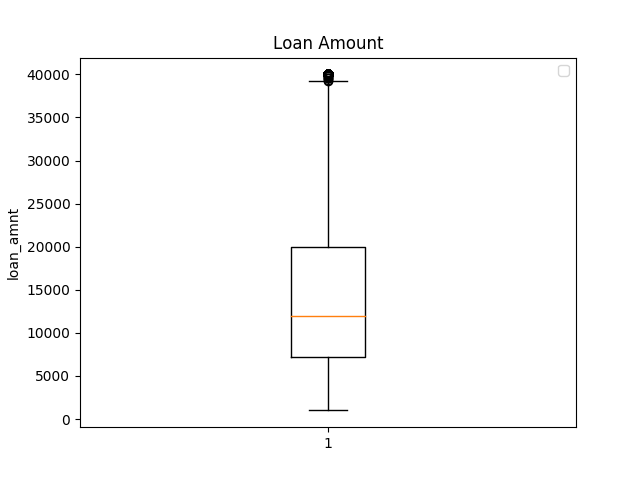

In [59]:
%%python

#using python magic for visualisations

import pandas
import matplotlib.pyplot as plt
from IPython.display import Image
import tempfile

df = pandas.read_csv("Loan_2017_20k.csv", delimiter = ',')

plt.clf()
plt.boxplot(df['loan_amnt'])
plt.ylabel('loan_amnt')
plt.legend()
plt.title("Loan Amount")
with tempfile.NamedTemporaryFile(suffix=".png") as fo:
    plt.savefig(fo.name)
    retval = Image(filename=fo.name)

Here we can see there are a few high outliers for loan amount, these outliers will need to be taken into consideration for the modelling phase

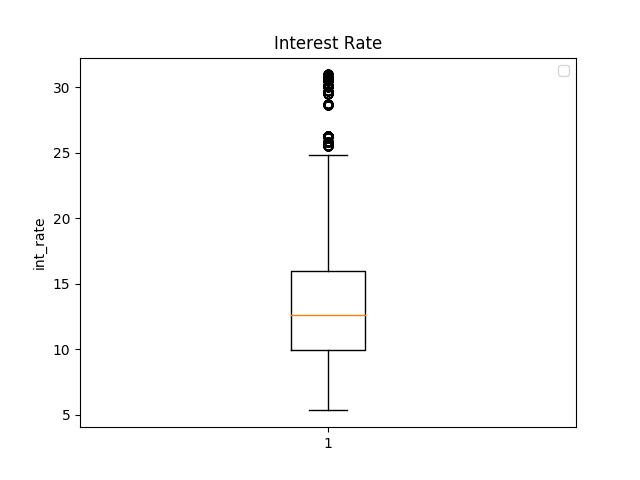

In [60]:
%%python

plt.clf()
plt.boxplot(df['int_rate'])
plt.ylabel('int_rate')
plt.legend()
plt.title("Interest Rate")
with tempfile.NamedTemporaryFile(suffix=".png") as fo:
    plt.savefig(fo.name)
    retval = Image(filename=fo.name)

Here we see a very iuntersting group of interest rates that are much higher than the rest. This will be worth investigating for the modelling step, to see what attributes cause such a high interest rate

In [61]:
//referencing categorical values from earlier
df.groupBy("grade").count().show()

+-----+-----+
|grade|count|
+-----+-----+
|    F|  267|
|    E|  865|
|    B| 6064|
|    D| 2548|
|    C| 6574|
|    A| 3590|
|    G|  162|
+-----+-----+



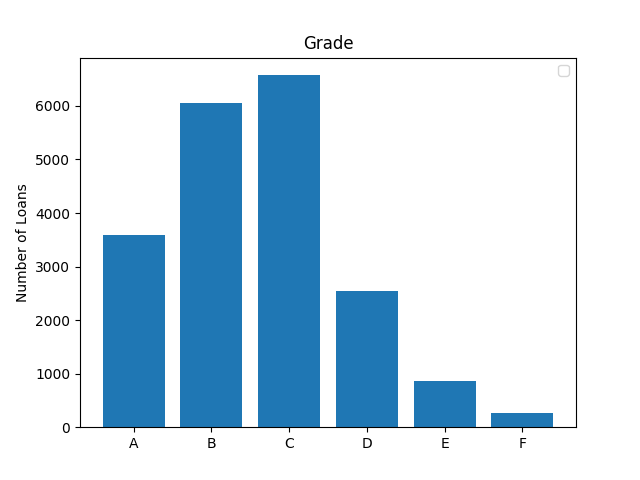

In [62]:
%%python
#using the above to easily visualise this data

keys = ('A','B','C','D','E','F')
values = (3590,6064,6574,2548,865,267)

plt.clf()
plt.bar(keys, values)
plt.ylabel('Number of Loans')
plt.legend()
plt.title("Grade")
with tempfile.NamedTemporaryFile(suffix=".png") as fo:
    plt.savefig(fo.name)
    retval = Image(filename=fo.name)

Most loans fall under a C and B grade. This is followed by A grade and D, and then a significant drop in E and F grades. This is expected, as a Loan business does not want to make 'bad' loans

In [63]:
//referencing this from earlier
df.groupBy("purpose").count().show()

+------------------+-----+
|           purpose|count|
+------------------+-----+
|             other| 1523|
|    small_business|  208|
|debt_consolidation|11029|
|       credit_card| 4184|
|            moving|  183|
|          vacation|  194|
|  renewable_energy|   17|
|             house|  131|
|               car|  238|
|    major_purchase|  508|
|           medical|  320|
|  home_improvement| 1535|
+------------------+-----+



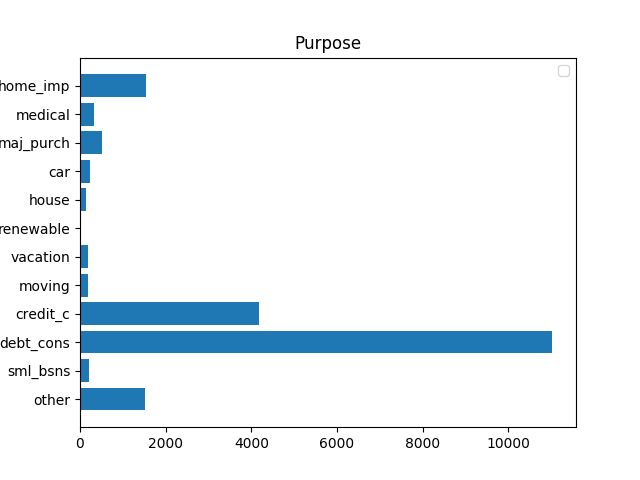

In [66]:
%%python

keys = ('other','sml_bsns','debt_cons','credit_c','moving','vacation',
        'renewable','house','car','maj_purch','medical','home_imp')
values = (1523,208,11029,4184,183,194,
          17,131,238,508,320,1535)

plt.clf()
plt.barh(keys, values)
plt.ylabel('Number of Loans')
plt.legend()
plt.title("Purpose")
with tempfile.NamedTemporaryFile(suffix=".png") as fo:
    plt.savefig(fo.name)
    retval = Image(filename=fo.name)

Here we can see that the primary loan purpose is for Debt Consolidation, followed by Credit Cards.

In [ ]:
//Merged Code by Alex and Robert